In [8]:


trainers_dict = eval(open('../output/figure1MNIST-20190516-203439.txt', 'r').read())
trainers_dict

{'Gauss': {'tr_scores': {1: [0.0049669501771529515, 0.9953833333333333],
   2: [0.0031091804078469676, 0.9984],
   5: [0.0012326190877395371, 0.9997833333333334],
   10: [0.0004902944389497861, 0.9999666666666667],
   20: [0.00017212788751348854, 1.0]},
  'te_scores': {1: [0.007727490313723683, 0.9825],
   2: [0.006614382103830576, 0.9857],
   5: [0.005606850644946098, 0.9871],
   10: [0.0052595595797523854, 0.9879],
   20: [0.005149456787668169, 0.9877]},
  'lin_train_mse': 4.908304e-11,
  'lin_train_ce': 0.0,
  'lin_test_mse': 0.006289064,
  'lin_test_ce': 0.0157},
 'Laplace': {'tr_scores': {1: [0.004820913852875431, 0.9965833333333334],
   2: [0.0024010541501455008, 0.9997166666666667],
   5: [0.0004360882775625214, 1.0],
   10: [4.2294746656746914e-05, 1.0],
   20: [9.878197787353807e-07, 1.0]},
  'te_scores': {1: [0.008543899180740118, 0.978],
   2: [0.007282978017441928, 0.9824],
   5: [0.006283972571790218, 0.9837],
   10: [0.006021467854268849, 0.9842],
   20: [0.00596924603171

MNIST


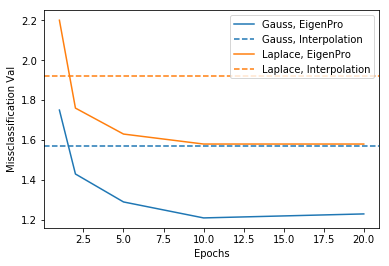

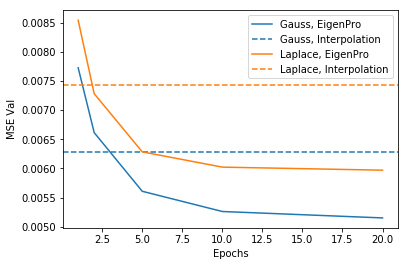

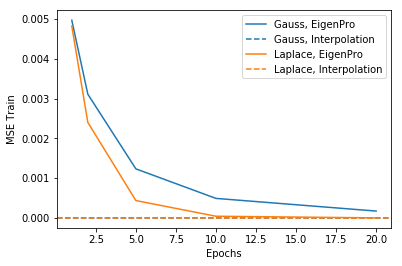

In [9]:
import matplotlib.pyplot as plt
ax = plt.gca()

print(dataset)

for name, trainer in trainers_dict.items():  
    
    dic = trainer['te_scores']
    
    epoch = [x for x in dic.keys()]
    mse   = [x[0] for x in dic.values()]
    miss  = [(1 - x[1]) * 100 for x in dic.values()]

    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(epoch, miss, label=name + ', EigenPro', color=color)      
    plt.axhline(y=trainer['lin_test_ce'] * 100, label=name + ', Interpolation', linestyle='--', color=color)

plt.xlabel('Epochs')
plt.ylabel('Missclassification Val')
plt.legend(loc='upper right')
plt.show()

ax.set_prop_cycle(None)

for name, trainer in trainers_dict.items():  
    
    dic = trainer['te_scores']
    
    epoch = [x for x in dic.keys()]
    mse   = [x[0] for x in dic.values()]
    miss  = [x[1] for x in dic.values()]

    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(epoch, mse, label=name + ', EigenPro', color=color) 
    plt.axhline(y=trainer['lin_test_mse'], label=name + ', Interpolation', linestyle='--', color=color)
    
plt.xlabel('Epochs')
plt.ylabel('MSE Val')
plt.legend(loc='upper right')
plt.show()

ax.set_prop_cycle(None)

for name, trainer in trainers_dict.items():  
    
    dic = trainer['tr_scores']
    
    epoch = [x for x in dic.keys()]
    mse   = [x[0] for x in dic.values()]
    miss  = [x[1] for x in dic.values()]

    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(epoch, mse, label=name + ', EigenPro', color=color) 
    plt.axhline(y=trainer['lin_train_mse'], label=name + ', Interpolation', linestyle='--', color=color)
    
plt.xlabel('Epochs')
plt.ylabel('MSE Train')
plt.legend(loc='upper right')
plt.show()


In [9]:
# del trainers
utils.reset()